In [1]:
import sys
#sys.path.append("~/Documents/qubitlab/python/qutip")
from libqubit2d import *
from scipy.optimize import *
from scipy.integrate import *

In [2]:
class ND(Model):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    class_params = ['params']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.evals, self.evecs = self.Hq().eigenstates()
        self.params['w'] = self.evals[1] - self.evals[0]
        self.params['psi0'] = self.evecs[0]
        self.update_pulse(params={'w':self.params['w']})
        
    def n(self):
        return num(2*self.params['N']+1, offset = -self.params['N'])

    def I(self):
        return identity(2*self.params['N']+1)

    def Hc(self):
        return 2*np.pi*4*self.params['Ec']*(self.n())**2

    def Hj(self):
        return -0.5*2*np.pi*self.params['Ej']*Qobj(np.diag(np.ones(2*self.params['N']), -1)+np.diag(np.ones(2*self.params['N']), 1))

    def Hq(self):
        return self.Hc() + self.Hj()

    def c(self):
        return 2*np.pi*sum([self.n().matrix_element(evecs[j], evecs[j+1])/self.n().matrix_element(evecs[0], evecs[1])\
                        * evecs[j]*evecs[j+1].dag() for j in range(0, len(self.evecs)-1)])
    def get_anharmonism(self, recount = False):
        if recount:
            self.evals, self.evecs = self.Hq().eigenstates()
        return -(self.evals[2] - self.evals[1]) + (self.evals[1] - self.evals[0])
    def collapse_list(self, c_op):
        collapse_list = []
        if(self.params['gamma_m']> 0):
            collapse_list.append(np.sqrt(gamma_m) * c_op )
        return collapse_list

    def S_basis(self):
        S = [[el[0] for el in evec.data.toarray()] for evec in self.evecs ]
        return Qobj(S)
    
    def convert_2toN(self, A2d):
        B2d = A2d.data.toarray()
        A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq.transform(self.evecs,True)

    def Hq_evecs(self):
        return self.Hq().eigenstates()[1]
    def Hq_evals(self):
        return self.Hq().eigenstates()[0]

    def rotatingFrame(self, expected_ops,  output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        szn = self.convert_2toN(sigmaz())
        U = (-1j*self.Hq()* 0).expm()
        dt = self.timelist()[-1] / (len(self.timelist())-1)
        dU = (1j*self.Hq() * dt).expm()
        for time_step, state in enumerate(output.states):
            time = dt * time_step
            U  = (1j*self.Hq() * time).expm()
            Ud = U.dag()
            for i, eop in enumerate(expected_ops):
                output.expect[i].append(expect(Ud*eop*U, state))    
        return output

In [3]:
class EasyShiftable:
    def shift(self, deltat):
        self.update(params={'a': self.params['a'] + deltat, 'b': self.params['b'] + deltat})
    def get_left(self, EPS = 1e-5):
        return self.params['a']
    def get_right(self, EPS = 1e-5):
        return self.params['b']


In [4]:
class PulseNXY(Pulse, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-5
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st) )*cos(w*t + axe )"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def get_shape(self):
        return self.shape
    def contour(self, offset=0):
        spf = sp.sympify(self.get_shape())/sp.sympify("cos(w*t+axe)") + offset
        tosubs = []
        for k,v in self.params.items():
            tosubs.append((sp.symbols(k),v))
        new_spf = spf.subs(tosubs)
        return lambdify({'t'},str(new_spf),'numpy')
    def set_correct_width(self):
        self.params['b'] = self.params['a'] + np.abs(self.params['phase'])/self.params['f']/self.extra['n_ge']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['a'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['b'])
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        q = None
        if not self.extra['default']:
            try:
                n = self.extra['qubit'].n()
            except AttributeError:
                print ("Error: no qubit link provided")
                return
            self.extra['n_ge'] = abs(self.extra['qubit'].n().transform(self.extra['qubit'].evecs).data.toarray()[0][1])
            self.params['w'] = self.extra['qubit'].params['w']
            if self.params['phase'] < 0 and not "__neg" in self.params:
                print("oppa")
                self.params['axe'] = self.params['axe']+np.pi
                self.params['__neg'] = True
            if self.params['phase'] > 0 and "__neg" in self.params:
                self.params['axe'] = self.params['axe']-np.pi
                self.params.pop('__neg')
            self.set_correct_width()
    def get_left(self):
        return self.extra['a']
    def get_right(self):
        return self.extra['b']        
                

In [5]:
class GaussianPulseNXY(PulseNXY, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-3
    default = Empty()
    default.params = {
        'f' : 0.1,
        'c' : 10,
        'st':10,
        'phase':0,
        'axe' : aroundX
    }
    default.time = {
        'points' : 100,
        'maxtime' : 20,
        'tlist' : np.linspace(0,10,100)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    default.shape = "f/(2*3.1415926)**0.5*(exp(-((t-c)/st)**2/2 ))*cos(w*t + axe)"
    class_params = ['params','time','shape', 'extra']
    def set_correct_width(self):
        self.params['f'] = self.params['phase']/self.extra['n_ge']/self.params['st']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['c']-self.params['st'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['c']+self.params['st'])
    def shift(self, deltat):
        self.update(params={'c': self.params['c'] + deltat})
    

In [6]:
class DownShifter:
    def shift_down(self):
        shape = self.get_shape()
        self.params['f'] = self.params['phase']/self.extra['n_ge']/self.params['st']
        a = fsolve(self.contour(-self.EPS), self.extra['a'])
        b = fsolve(self.contour(-self.EPS), self.extra['b'])
        
            
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy(kvargs, params, just_update)
        self.shift_down()

In [7]:
class WindowedPulse(Pulse):
    def make_window(self):
        self.shape = self.shape + "*0.5*(tanh((t-a)/st2) - tanh((t-b)/st2) )"
    def reset_magnitude(self):
        cf = self.contour()
        try:
            n_ge = self.extra['n_ge']
        except AttributeError:
            n_ge = 1
        ph = quad(cf, -np.inf, np.inf)[0]*n_ge
        self.params['f'] = self.params['phase']/ph * self.params['f']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy(kvargs, params, just_update)
        if not just_update:
            self.make_window()
        self.reset_magnitude()

In [8]:
class DragCorrectedPulse:
    def correct(self):
        if not 'original_shape' in self.__dict__:
            self.original_shape = self.shape
        old_shape = sp.sympify(self.original_shape)
        w,t,axe = sp.symbols('w t axe')
        new_shape_y = sp.diff(old_shape/(sp.cos(w*t + axe)), t)
        new_shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*new_shape_y/2/self.extra['qubit'].get_anharmonism()
        self.shape = str(old_shape - new_shape_y)
    def get_shape(self):
        if 'original_shape' in self.__dict__:
            return self.original_shape
        else:
            return self.shape
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.correct()    

In [9]:
class PulseNXYDrag(DragCorrectedPulse, PulseNXY):
    pass    
class GaussianPulseNXYDrag(DragCorrectedPulse, GaussianPulseNXY):
    pass
class GWPulseNXYDrag(DragCorrectedPulse, WindowedPulse, GaussianPulseNXY):
    pass

In [10]:
class PulseSequence(Pulse):
    default = Empty()
    default.params = {}
    default.pulses = []
    default.shape = "0"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params', 'pulses','shape','time']
    #TODO : funny contructor.
    def append_pulse(self, pulse):
        #next line - shift pulse in time if it's superimposed with sequence
        if len(self.pulses) > 0 and self.pulses[-1].get_right()  > pulse.get_left():
            #TODO : find end of pulse correctly!! (when magnitude < EPS)
            try:
                pulse.shift(self.pulses[-1].get_right() - pulse.get_left()) 
            except AttributeError:
                print ("Error: no shift function available for pulse. Please, provide pulse with a shift function or shift in manually to available time")
        if self.time['maxtime'] < pulse.get_right():
            self.time['maxtime'] = pulse.get_right() + (pulse.get_right() - pulse.get_left())*0.1
            self.time['tlist'] = np.linspace(0, self.time['maxtime'], self.time['points'])
        p = len(self.pulses)
        self.pulses.append(pulse)
        old_symbols_str = str()
        new_symbols_str = str()
        for k,v in pulse.params.items():
            self.params[k+'_'+str(p)] = v
            old_symbols_str += k + ' '
            new_symbols_str += (k + '_' +str(p) + ' ')
        old_shape = sp.sympify(pulse.shape)
        old_symbols = sp.symbols(old_symbols_str)
        new_symbols = sp.symbols(new_symbols_str)
        new_shape = old_shape.subs(list(zip(list(old_symbols),list(new_symbols))))
        self.shape = str(sp.sympify(self.shape) + new_shape)

In [11]:
class PulseSequenceNXY(PulseSequence, Pulse):
    pass

In [12]:
class SingleQND(ND):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    default.pulse = [
        
    ]
    class_params = ['params','pulse']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        if not 'pulse' in kvargs:
            self.pulse = [PulseNXYDrag(params = { 'a': 10, 'f' : 0.003,'phase':np.pi,'st':1 },
                  time = {'maxtime' : 1200,'points':1200}, extra = {'qubit' : self,'default':False})]
    def HTD(self):
        return [self.Hq(), [self.n(), self.pulse[0].shape]]
    
    def update_pulse(self, **new_params):
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],expected_ops, args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        
    def solveRF(self, expected_ops2d = [sigmax(), sigmay(), sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],[], args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        self.rotatingFrame(expected_ops)
        
    def plot(self, ylim = [-1.5,1.1]):
        output = []
        try:
            output = self.result
        except AttributeError:
            print ("Error: no present result")
            return
        fig, axes = plt.subplots(1,1, figsize=(13,5), sharex=True)
        if "f" in self.pulse[0].params and 'a' in self.pulse[0].params and 'b' in self.pulse[0].params and 'phase' in self.pulse[0].params:
            axes.set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(self.pulse[0].params['f'],self.pulse[0].params['a']-self.pulse[0].params['b'],self.pulse[0].params['phase']));
        labels = ['0t','1t','2t']
        labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
        for idx in range(3):
            axes.plot(self.timelist(), output.expect[idx], label=labels[idx] + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            axes.set_ylim(*ylim)
            axes.legend(bbox_to_anchor = [0,0],loc = "lower left")
            axes.set_xlabel('Time')
        axes.set_ylabel('Occupation probability')

In [13]:
class APESequence(PulseSequence):
    #TODO : funny contructor.
    def __init__(self, PulseClass, repeat, phase, **kvargs):
        super().__init__()
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = 0
        self.append_pulse(PulseClass(**kvargs))
        for i in range(repeat):
            kvargs['params']['phase'] = np.pi/2
            self.append_pulse(PulseClass(**kvargs))
            kvargs['params']['phase'] = -np.pi/2
            self.append_pulse(PulseClass(**kvargs))
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = phase
        self.append_pulse(PulseClass(**kvargs))

# Works

In [14]:
model = SingleQND()

In [57]:
GLEB_GW_PULSE = GWPulseNXYDrag(params = {"c":50, "a":50-25, "b":50+25, 'f' : 0.03,'phase':np.pi/2, "st":10, 'st2':1.5,'axe':0 },
            extra = {'qubit' : model,'default':False}, time={"maxtime":150, "points":2000})

In [44]:
ape = APESequence(GWPulseNXYDrag, 5, np.pi/4, params = {"c":50, "a":50-25, "b":50+25, 'f' : 0.03,'phase':np.pi/2, "st":1.5, 'st2':1.5,'axe':0 },
            extra = {'qubit' : model,'default':False})
ape.time['points'] = 500

{'params': {'c': array([ 60.20303657])}}
oppa
{'params': {'c': array([ 79.04934814])}}


/home/gleb/py35/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'params': {'c': array([ 94.9550424])}}
oppa
{'params': {'c': array([ 110.19983675])}}


/home/gleb/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars


{'params': {'c': array([ 116.80135504])}}
oppa
{'params': {'c': array([ 132.0461494])}}
{'params': {'c': array([ 138.64766768])}}
oppa
{'params': {'c': array([ 153.89246204])}}
{'params': {'c': array([ 160.49398032])}}
oppa
{'params': {'c': array([ 175.73877468])}}
{'params': {'c': array([ 182.34029297])}}


/home/gleb/py35/lib/python3.5/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """
/home/gleb/py35/lib/python3.5/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in subtract
  """


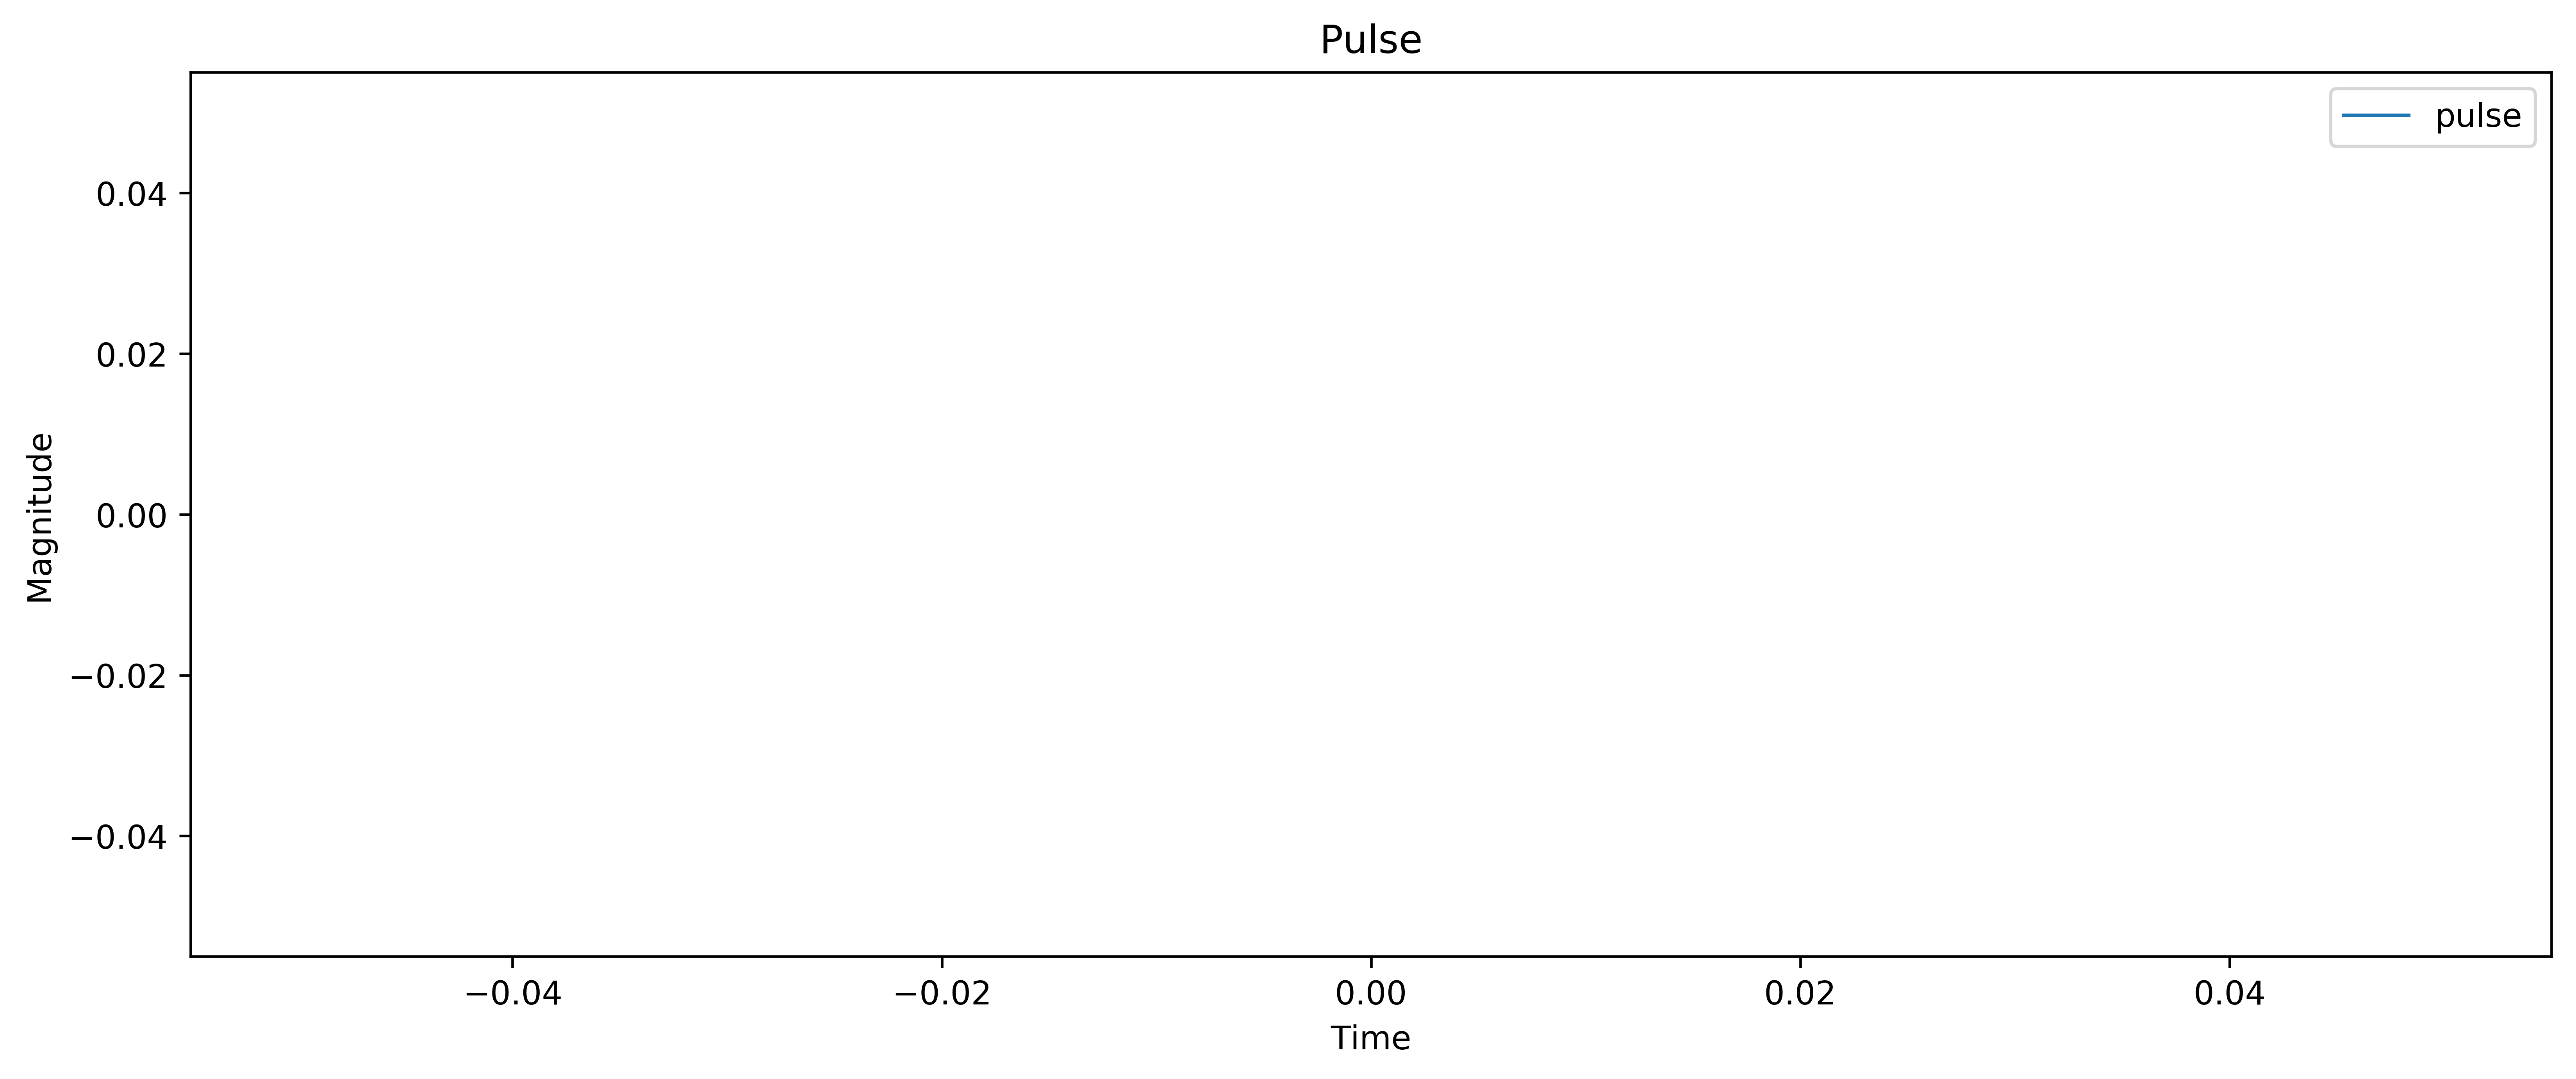

In [45]:
ape.time["points"] = 1000
ape.plot()

In [46]:
model.pulse[0] = ape

In [47]:
model.params['psi0'] = (model.evecs[0] - 1j*model.evecs[1])/2**0.5

In [48]:
model.solveRF()

10.0%. Run time:   3.10s. Est. time left: 00:00:00:27
20.0%. Run time:   6.11s. Est. time left: 00:00:00:24
30.0%. Run time:   8.91s. Est. time left: 00:00:00:20
40.0%. Run time:  12.06s. Est. time left: 00:00:00:18
50.0%. Run time:  15.14s. Est. time left: 00:00:00:15
60.0%. Run time:  18.01s. Est. time left: 00:00:00:12
70.0%. Run time:  21.03s. Est. time left: 00:00:00:09
80.0%. Run time:  24.22s. Est. time left: 00:00:00:06
90.0%. Run time:  27.34s. Est. time left: 00:00:00:03
Total run time:  30.14s


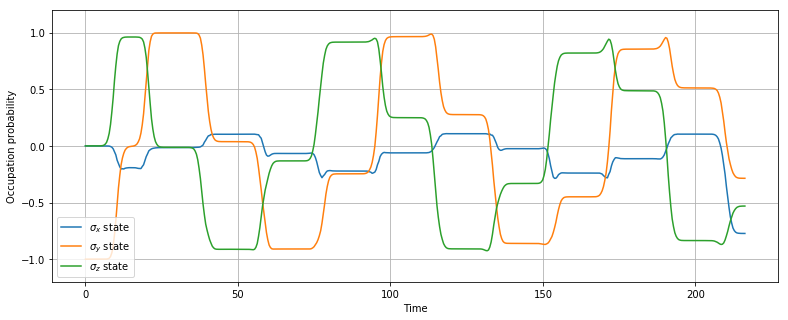

In [49]:
model.plot([-1.2,1.2])
plt.grid()

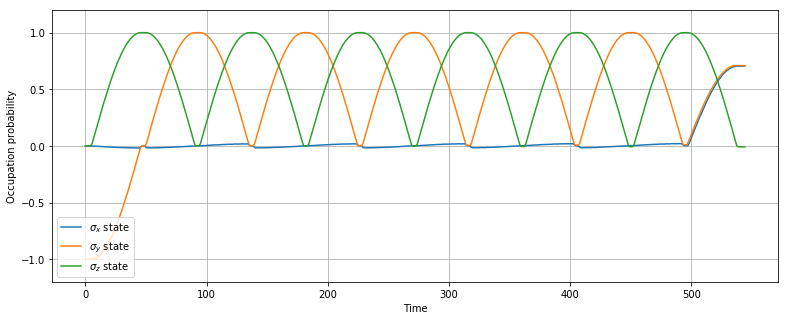

In [25]:
model.plot([-1.2,1.2])
plt.grid()

# NOT works

In [500]:
testq = SingleQND()

g = PulseNXYDrag(params = { 'a': 5, 'f' : 0.3,'phase':np.pi/2,'st':0.5,'axe':PulseNXY.aroundY },
                  time = {'maxtime' : 20,'points':200}, extra = {'qubit' : testq,'default':False})

testq.params['psi0'] = (testq.evecs[0] + testq.evecs[1])/(2)**0.5
#g.params['axe'] = np.pi
testq.pulse[0]=g

In [501]:
print(testq.args())
#testq.params['axe']


{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}
{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}


In [502]:
print(g.shape)

0.22821600457627*f*((-tanh((-a + t)/st)**2 + 1)/st - (-tanh((-b + t)/st)**2 + 1)/st)*sin(axe + t*w) + 0.5*f*(tanh((-a + t)/st) - tanh((-b + t)/st))*cos(axe + t*w)


{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}
10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.14s. Est. time left: 00:00:00:00
40.0%. Run time:   0.19s. Est. time left: 00:00:00:00
50.0%. Run time:   0.23s. Est. time left: 00:00:00:00
60.0%. Run time:   0.27s. Est. time left: 00:00:00:00
70.0%. Run time:   0.32s. Est. time left: 00:00:00:00
80.0%. Run time:   0.36s. Est. time left: 00:00:00:00
90.0%. Run time:   0.40s. Est. time left: 00:00:00:00
Total run time:   0.44s


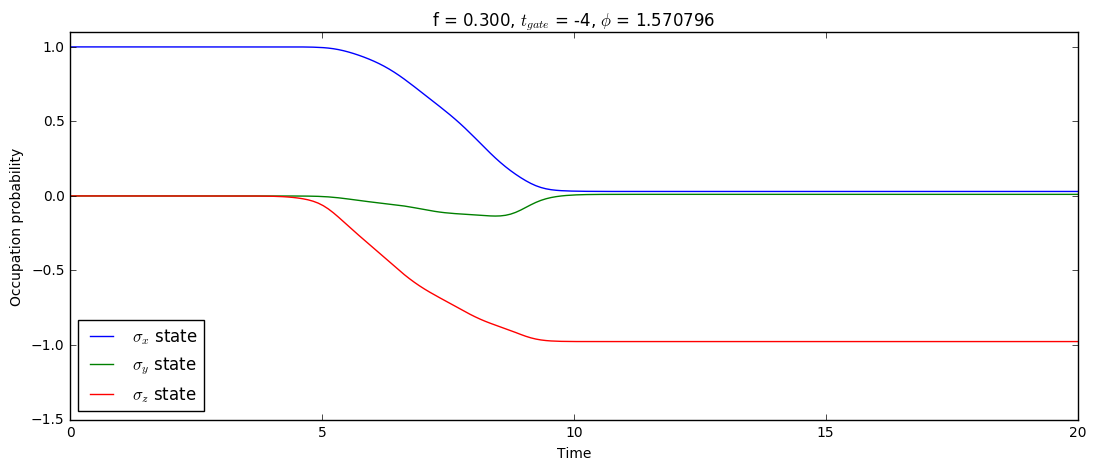

In [503]:
testq.solveRF()
testq.plot()

10.0%. Run time:   1.99s. Est. time left: 00:00:00:17
20.0%. Run time:   3.97s. Est. time left: 00:00:00:15
30.0%. Run time:   5.83s. Est. time left: 00:00:00:13
40.0%. Run time:   7.60s. Est. time left: 00:00:00:11
50.0%. Run time:   9.52s. Est. time left: 00:00:00:09
60.0%. Run time:  11.44s. Est. time left: 00:00:00:07
70.0%. Run time:  13.45s. Est. time left: 00:00:00:05
80.0%. Run time:  15.37s. Est. time left: 00:00:00:03
90.0%. Run time:  17.25s. Est. time left: 00:00:00:01
Total run time:  19.15s


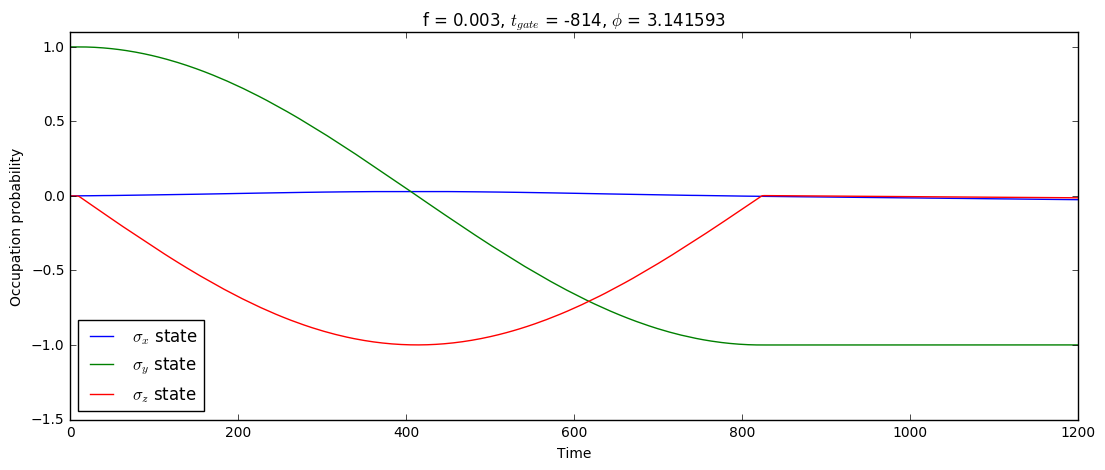

In [454]:
testq.solveRF()
testq.plot()

In [437]:
m2 = SingleQND()
pn = PulseNXYDrag(params = { 'a': 5, 'f' : 0.3,'phase':-np.pi/2,'st':0.5, 'axe':0 },
                  time = {'maxtime' : 20,'points':1000}, extra = {'qubit' : m2,'default':False})
pn.params['axe']

3.141592653589793